## Get image from a Lepton camera

Show it has a Gray8 (heatmap) image.

[ WARN:0@2157.900] global cap_v4l.cpp:913 open VIDEOIO(V4L2:/dev/video3): can't open camera by index
[ WARN:0@2157.900] global cap.cpp:478 open VIDEOIO(V4L2): backend is generally available but can't be used to capture by index


VideoCapture: True
Frame healthy? True


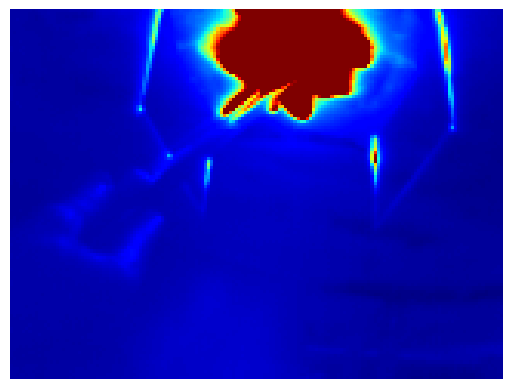

In [ ]:
import time
import cv2
import matplotlib.pyplot as plt
import numpy as np
from flirpy.camera.lepton import Lepton

with Lepton() as cam:
  cam.setup_video()
  print("VideoCapture:", cam.cap.isOpened())

  result, frame = cam.cap.read() # because cam.grap() breaks
  print("Frame healthy?", result)

  if not result:
    print("Can't receive frame (stream end?). Exiting ...")
  else:
    frame = frame.reshape((120 + 2, 320)) # 120 + 2 for telemetry & 160 * 2

    # Gray16
    frame_16 = frame.view(np.uint16)
    frame_16 = frame_16[:-2, :]  # remove telemetry
    cv2.imwrite("lepton_camera.tiff", frame_16)

    # Gray8 to visualize
    norm_frame = cv2.normalize(frame_16, None, 0, 255, cv2.NORM_MINMAX)
    norm_frame = norm_frame.astype(np.uint8)
    cv2.imwrite(f"saves/{time.time_ns()}_8.png", norm_frame)
    plt.imshow(norm_frame, cmap='jet', interpolation='nearest')
    plt.axis("off")
    plt.show()

  cam.cap.release()


## Get temperature from a pixel in a Gray16 image

Gray16 image shape: (120, 160)
Pixel at (85, 10) in Gray16 image: 45536
Pixel at (85, 10) in Celsius: 182.21000000000004


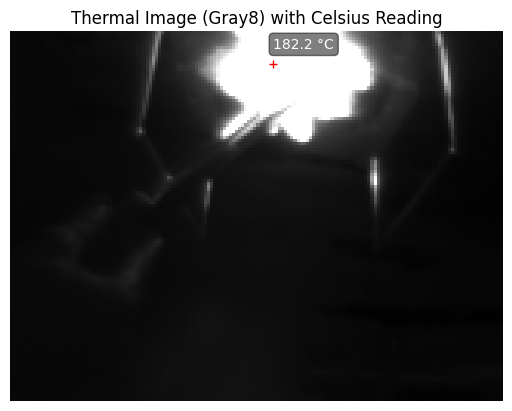

In [23]:
import cv2

gray16_image = cv2.imread("test.tiff", cv2.IMREAD_UNCHANGED)
print("Gray16 image shape:", gray16_image.shape)  # should be (120, 160)

x = 85
y = 10

# calculate the pixel value in Celsius (through the gray16 image)
pixel_value = gray16_image[y, x]
print(f"Pixel at ({x}, {y}) in Gray16 image:", pixel_value)
pixel_celsius = (pixel_value / 100) - 273.15
print(f"Pixel at ({x}, {y}) in Celsius:", pixel_celsius)

# convert the gray16 image into a gray8 to show the result
gray8_image = np.zeros((120, 160), dtype=np.uint8)
gray8_image = cv2.normalize(gray16_image, gray8_image, 0, 255, cv2.NORM_MINMAX)
gray8_image = np.uint8(gray8_image)

# plot
fig, ax = plt.subplots()
ax.imshow(gray8_image, cmap="gray")

ax.plot(x, y, "r+")
ax.text(
  x,
  y - 5,
  f"{pixel_celsius:.1f} °C",
  color="white",
  fontsize=10,
  bbox=dict(facecolor="black", alpha=0.5, boxstyle="round,pad=0.3"),
)

ax.set_title("Thermal Image (Gray8) with Celsius Reading")
plt.axis("off")
plt.show()

## Get camera video from a Lepton camera

In [ ]:
import cv2
import time
import numpy as np
from flirpy.camera.lepton import Lepton
import sys
import datetime

# Initialize Lepton camera
cam = Lepton()
cam.setup_video()
if not cam.cap.isOpened():
    print("Error: Camera not opened.")
    sys.exit(1)
print("VideoCapture:", cam.cap.isOpened())

# CONSTANTS
TELEMETRY_H = 2
FRAME_W = int(cam.cap.get(cv2.CAP_PROP_FRAME_WIDTH))  # = 160
FRAME_H = int(cam.cap.get(cv2.CAP_PROP_FRAME_HEIGHT)) - TELEMETRY_H  # = 120
print(f"Frame size: {FRAME_W}x{FRAME_H}")

# Start video capture
print("Waiting for camera to warm up...")
time.sleep(0.1)
result, frame = cam.cap.read()
if not result:
    print("Can't receive frame. Exiting ...")
    cam.close()
    sys.exit(1)

print("Starting video capture...")
start_time = time.time()
last_time = start_time
sum_time = 0.0
sum_fps = 0.0

frame_count = 0
max_frames = 10000
frames_16 = []
frames = []
ts = time.time_ns()

while frame_count < max_frames:
    result, frame = cam.cap.read()
    if not result:
        print("Can't receive frame. Exiting ...")
        cam.close()
        break

    # height + 2 (for telemetry) & width * 2
    frame = frame.reshape((FRAME_H + TELEMETRY_H, FRAME_W * 2))

    # Gray16
    frame_16 = frame.view(np.uint16)
    frame_16 = frame_16[:-2, :]  # remove telemetry
    cv2.imwrite(f"saves/video_tiff/{ts}_{frame_count}.tiff", frame_16)

    # Gray8 to visualize
    norm_frame = cv2.normalize(frame_16, None, 0, 255, cv2.NORM_MINMAX)
    norm_frame = norm_frame.astype(np.uint8)

    # Add frame to [] (in COLORMAP_JET, COLORMAP_INFERNO or COLORMAP_HOT)
    color_frame = cv2.applyColorMap(norm_frame, cv2.COLORMAP_JET)
    frames.append({
        "gray16": frame_16,
        "gray8": norm_frame,
        "color": color_frame
    })
    print(f"frame n°{frame_count}")

    # See stats for each frame
    now = time.time()
    delta_ms = (now - last_time) * 1000
    last_time = now
    sum_time += delta_ms
    actual_fps = 1000 / delta_ms if delta_ms > 0 else 0
    sum_fps += actual_fps
    # print(f"Frame {frame_count}: {actual_fps:.0f} fps ; Δt = {delta_ms:.3f} ms")
    frame_count += 1

avg_fps = sum_fps / frame_count if frame_count > 0 else 0
print(f"Average FPS: {sum_fps / frame_count:.2f}")
print(f"Average frame time: {sum_time / frame_count:.2f} ms")
end_time = time.time()
print(f"Total time: {end_time - start_time:.2f} seconds")
cam.close()

# Export video from frames
time_stamp = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
video_writer = cv2.VideoWriter(
    f"saves/lepton_{time_stamp}.avi",
    cv2.VideoWriter_fourcc(*"XVID"),
    fps=avg_fps,
    frameSize=(FRAME_W, FRAME_H),
    isColor=True,
)
for frame in frames:
    video_writer.write(frame["color"])

video_writer.release()
print(f"Saved {frame_count} frames to {time_stamp}.avi")

In [ ]:
import cv2
import numpy as np
from pathlib import Path

# Get all TIFF files from the video_tiff directory
tiff_dir = Path("./saves/video_tiff/")
tiff_files = sorted(list(tiff_dir.glob("*.tiff")))

print(f"Found {len(tiff_files)} TIFF files")

# Read all gray16 images
gray16_images = []
for tiff_file in tiff_files:
  # Read as unchanged to preserve 16-bit data
  img = cv2.imread(str(tiff_file), cv2.IMREAD_UNCHANGED)
  if img is not None:
    gray16_images.append({
      'filename': tiff_file.name,
      'image': img
    })
  else:
    print(f"Failed to load: {tiff_file.name}")

print(f"Successfully loaded {len(gray16_images)} gray16 images")

Found 11664 TIFF files
Successfully loaded 11664 gray16 images


In [3]:
import cv2
import numpy as np
from pathlib import Path

# Function to convert pixel value to Celsius
def pixel_to_celsius(pixel_value):
    return (pixel_value / 100) - 273.15

# Analyze all images for temperature data
temperature_data = []

for img_data in gray16_images:
    filename = img_data['filename']
    image = img_data['image']
    
    # Get the maximum temperature pixel in this image
    max_pixel_value = np.max(image)
    max_temp_celsius = pixel_to_celsius(max_pixel_value)
    
    # Find the location of the maximum temperature
    max_locations = np.where(image == max_pixel_value)
    max_y, max_x = max_locations[0][0], max_locations[1][0]  # Get first occurrence
    
    # Get some statistics for this image
    min_pixel_value = np.min(image)
    min_temp_celsius = pixel_to_celsius(min_pixel_value)
    mean_pixel_value = np.mean(image)
    mean_temp_celsius = pixel_to_celsius(mean_pixel_value)
    
    temperature_data.append({
        'filename': filename,
        'max_temp_celsius': max_temp_celsius,
        'max_pixel_value': max_pixel_value,
        'max_location': (max_x, max_y),
        'min_temp_celsius': min_temp_celsius,
        'mean_temp_celsius': mean_temp_celsius
    })
    
    # print(f"{filename}: Max temp = {max_temp_celsius:.2f}°C at pixel ({max_x}, {max_y})")

# Sort by maximum temperature (highest first)
temperature_data_sorted = sorted(temperature_data, key=lambda x: x['max_temp_celsius'], reverse=True)

print("\n=== TOP 10 HIGHEST TEMPERATURES ===")
for i, data in enumerate(temperature_data_sorted[:10]):
    print(f"{i+1:2d}. {data['filename']}: {data['max_temp_celsius']:.2f}°C at ({data['max_location'][0]}, {data['max_location'][1]})")

print("\n=== OVERALL STATISTICS ===")
all_max_temps = [data['max_temp_celsius'] for data in temperature_data]
print(f"Highest temperature overall: {max(all_max_temps):.2f}°C")
print(f"Lowest maximum temperature: {min(all_max_temps):.2f}°C")
print(f"Average of maximum temperatures: {np.mean(all_max_temps):.2f}°C")

# Find the image with the absolute highest temperature
hottest_image = temperature_data_sorted[0]
print(f"\nHottest image: {hottest_image['filename']} with {hottest_image['max_temp_celsius']:.2f}°C")


=== TOP 10 HIGHEST TEMPERATURES ===
 1. 1753345736384681849_0.tiff: 182.21°C at (82, 36)
 2. 1753345736384681849_1.tiff: 182.21°C at (82, 36)
 3. 1753345736384681849_10.tiff: 182.21°C at (82, 36)
 4. 1753345736384681849_100.tiff: 182.21°C at (86, 38)
 5. 1753345736384681849_1000.tiff: 182.21°C at (91, 37)
 6. 1753345736384681849_1001.tiff: 182.21°C at (91, 37)
 7. 1753345736384681849_1002.tiff: 182.21°C at (91, 37)
 8. 1753345736384681849_1003.tiff: 182.21°C at (91, 37)
 9. 1753345736384681849_1004.tiff: 182.21°C at (91, 37)
10. 1753345736384681849_1005.tiff: 182.21°C at (91, 37)

=== OVERALL STATISTICS ===
Highest temperature overall: 182.21°C
Lowest maximum temperature: 44.55°C
Average of maximum temperatures: 181.53°C

Hottest image: 1753345736384681849_0.tiff with 182.21°C


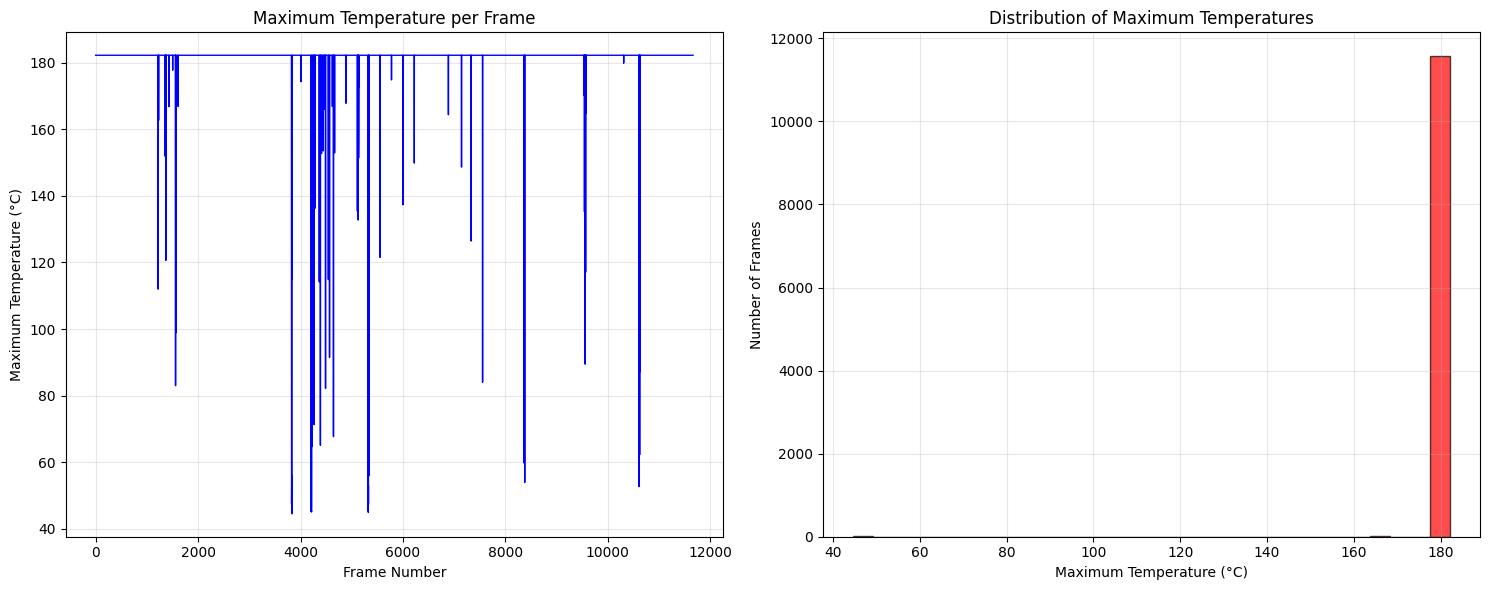

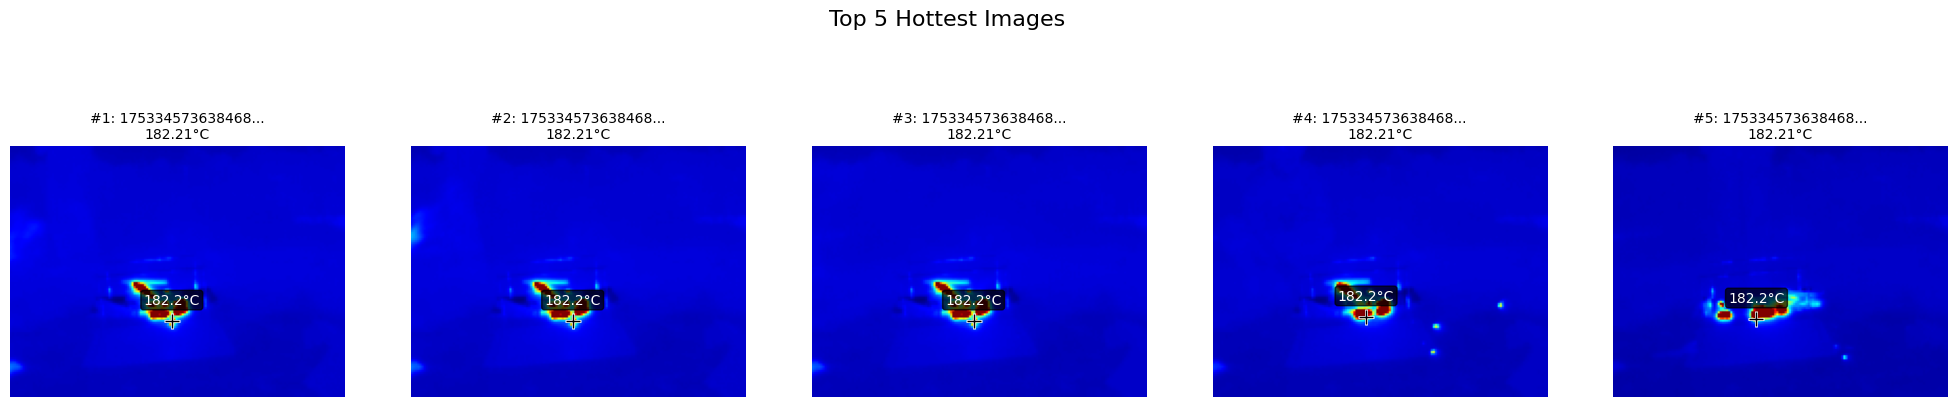


=== TEMPERATURE ANALYSIS SUMMARY ===
Total frames analyzed: 11664
Temperature range: 44.55°C to 182.21°C
Temperature span: 137.66°C
Standard deviation: 8.64°C


In [ ]:
import matplotlib.pyplot as plt

# Create a visualization of temperature distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Maximum temperatures over time (assuming filenames are chronological)
max_temps = [data['max_temp_celsius'] for data in temperature_data]
ax1.plot(range(len(max_temps)), max_temps, 'b-', linewidth=1)
ax1.set_xlabel('Frame Number')
ax1.set_ylabel('Maximum Temperature (°C)')
ax1.set_title('Maximum Temperature per Frame')
ax1.grid(True, alpha=0.3)

# Plot 2: Temperature distribution histogram
ax2.hist(max_temps, bins=30, alpha=0.7, color='red', edgecolor='black')
ax2.set_xlabel('Maximum Temperature (°C)')
ax2.set_ylabel('Number of Frames')
ax2.set_title('Distribution of Maximum Temperatures')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Show the top 5 hottest images with temperature overlay
fig, axes = plt.subplots(1, 5, figsize=(25, 5))

for i, temp_data in enumerate(temperature_data_sorted[:5]):
    # Find the corresponding image data
    image_data = None
    for img_data in gray16_images:
        if img_data['filename'] == temp_data['filename']:
            image_data = img_data
            break
    
    if image_data:
        # Convert to gray8 for visualization
        gray16_img = image_data['image']
        
        # Rotate the image 180 degrees since camera was upside down
        gray16_img = cv2.rotate(gray16_img, cv2.ROTATE_180)
        
        gray8_img = cv2.normalize(gray16_img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        
        # Apply colormap
        color_img = cv2.applyColorMap(gray8_img, cv2.COLORMAP_JET)
        color_img_rgb = cv2.cvtColor(color_img, cv2.COLOR_BGR2RGB)
        
        # Plot the image
        axes[i].imshow(color_img_rgb)
        
        # Mark the hottest pixel (adjust coordinates for 180-degree rotation)
        original_max_x, original_max_y = temp_data['max_location']
        # For 180-degree rotation: new_x = width - 1 - original_x, new_y = height - 1 - original_y
        height, width = gray16_img.shape
        rotated_max_x = width - 1 - original_max_x
        rotated_max_y = height - 1 - original_max_y
        
        axes[i].plot(rotated_max_x, rotated_max_y, 'w+', markersize=12, markeredgewidth=2)
        axes[i].plot(rotated_max_x, rotated_max_y, 'k+', markersize=10, markeredgewidth=1)
        
        # Add temperature text
        axes[i].text(rotated_max_x, rotated_max_y - 8, f"{temp_data['max_temp_celsius']:.1f}°C", 
                     color='white', fontsize=10, ha='center',
                     bbox=dict(facecolor='black', alpha=0.7, boxstyle="round,pad=0.2"))
        
        # Set title with ranking and filename
        axes[i].set_title(f"#{i+1}: {temp_data['filename'][:15]}...\n{temp_data['max_temp_celsius']:.2f}°C", 
                         fontsize=10)
        axes[i].axis('off')

plt.suptitle("Top 5 Hottest Images", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

print("\n=== TEMPERATURE ANALYSIS SUMMARY ===")
print(f"Total frames analyzed: {len(temperature_data)}")
print(f"Temperature range: {min(all_max_temps):.2f}°C to {max(all_max_temps):.2f}°C")
print(f"Temperature span: {max(all_max_temps) - min(all_max_temps):.2f}°C")
print(f"Standard deviation: {np.std(all_max_temps):.2f}°C")